1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:


file_name = "./data/data_000637.txt"

#creo un numero random tra 10000 e il numero massimo di righe
tmp = pd.read_csv(file_name)
N=rnd.randint(10000,len(tmp))
print(f"Total number of rows: {len(tmp)}")
print(f"N: {N}")

data = pd.read_csv(file_name, nrows=N) #leggo N righe del file
data


Total number of rows: 1310720
N: 947583


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
947578,1,0,139,3869208682,861,0
947579,1,0,43,3869208682,854,6
947580,1,1,6,3869208682,863,15
947581,1,0,57,3869208682,859,16


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [3]:
#x= massimo della colonna BX_COUNTER
x=data["BX_COUNTER"].max()

print("The max of BX_COUNTER is:", x)

The max of BX_COUNTER is: 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [4]:


#calcolo i tempi per ogni riga in ns e li aggiungo nella nuova colonna
data['ABS_TIME'] = x*25*data['ORBIT_CNT'] + 25*data['BX_COUNTER'] + (25/30)*data['TDC_MEAS']

#converto la nuova colonna in time-series:
data['ABS_TIME'] = pd.to_datetime(data['ABS_TIME'], unit='ns')
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,1970-01-04 23:44:09.004934896
1,1,0,124,3869200167,2374,27,1970-01-04 23:44:09.004934897
2,1,0,63,3869200167,2553,28,1970-01-04 23:44:09.004939373
3,1,0,64,3869200167,2558,19,1970-01-04 23:44:09.004939490
4,1,0,64,3869200167,2760,25,1970-01-04 23:44:09.004944545
...,...,...,...,...,...,...,...
947578,1,0,139,3869208682,861,0,1970-01-04 23:44:09.763370675
947579,1,0,43,3869208682,854,6,1970-01-04 23:44:09.763370505
947580,1,1,6,3869208682,863,15,1970-01-04 23:44:09.763370737
947581,1,0,57,3869208682,859,16,1970-01-04 23:44:09.763370638


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [5]:
#leggo l'intero file
data = pd.read_csv(file_name)
print("OK")
#calcolo i tempi per ogni riga in ns e li aggiungo nella colonna "ABS TIME"
data['ABS_TIME'] = x*25*data['ORBIT_CNT'] + 25*data['BX_COUNTER'] + (25/30)*data['TDC_MEAS']

#converto da ns al formato ore-minuti-secondi
data['ABS_TIME'] = pd.to_timedelta(data['ABS_TIME'])
data

OK


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,3 days 23:44:09.004934896
1,1,0,124,3869200167,2374,27,3 days 23:44:09.004934897
2,1,0,63,3869200167,2553,28,3 days 23:44:09.004939373
3,1,0,64,3869200167,2558,19,3 days 23:44:09.004939490
4,1,0,64,3869200167,2760,25,3 days 23:44:09.004944545
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3 days 23:44:09.985075886
1310716,1,1,4,3869211171,763,11,3 days 23:44:09.985075909
1310717,1,0,64,3869211171,764,0,3 days 23:44:09.985075925
1310718,1,0,139,3869211171,769,0,3 days 23:44:09.985076050


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [6]:
count = data.groupby(['TDC_CHANNEL']).count()
noisy_ch=count.sort_values(by="HEAD",ascending=False).iloc[0:3] 
print(noisy_ch)


               HEAD    FPGA  ORBIT_CNT  BX_COUNTER  TDC_MEAS  ABS_TIME
TDC_CHANNEL                                                           
139          108059  108059     108059      108059    108059    108059
64            66020   66020      66020       66020     66020     66020
63            64642   64642      64642       64642     64642     64642


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [7]:
non_empty_orbits=len(data.groupby("ORBIT_CNT").count())
print(f"The non-empty orbits are: {non_empty_orbits}")

The non-empty orbits are: 11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [8]:
unique_orb_139=len(data[data["TDC_CHANNEL"]==139].groupby("ORBIT_CNT").count())
print(f"The unique orbits with at least one measurement from TDC_CHANNEL=139 are: {unique_orb_139}")

The unique orbits with at least one measurement from TDC_CHANNEL=139 are: 10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [9]:
FPGA_0 = pd.Series(data[data['FPGA']==0]['TDC_CHANNEL'].value_counts())
FPGA_1 = pd.Series(data[data['FPGA']==1]['TDC_CHANNEL'].value_counts())
FPGA_0


139    75617
64     64581
63     63724
61     48699
62     48275
       ...  
130       33
137       32
30         4
129        2
39         1
Name: TDC_CHANNEL, Length: 124, dtype: int64

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0.5, 0, 'TDC channel')

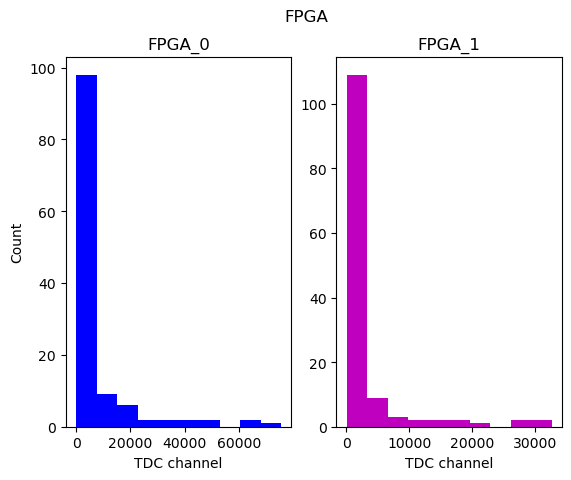

In [15]:
fig, (ax1, ax2, ) = plt.subplots(1, 2,)
fig.suptitle('FPGA')

ax1.hist(FPGA_0, color='b')
ax1.set_title('FPGA_0')
ax1.set_xlabel('TDC channel')
ax1.set_ylabel('Count')

ax2.hist(FPGA_1, color='m')
ax2.set_title('FPGA_1')
ax2.set_xlabel('TDC channel')